# Úkol č. 1 - redukce dimenzionality a binární klasifikace

  * **Deadline je 22. 4. 2024, 23:59:59**, pokud odevzdáte úkol do 29. 4. 2024, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * Experimentujte se standardizací/normalizací dat.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.


  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky a pokuste modely vylepšit
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import pickle

import random

import matplotlib.pyplot as plt

random_seed = 42

# Data Exploration

First of all, lets become acquainted with our data and explore it a little bit:

In [2]:
df_data = pd.read_csv('train.csv')

Split our data into labels and images, and into train, validation datasets and prepare cross validation datasets.

In [3]:
def split_data(data):
    print(f'Data shape: {data.shape}')
    labels = data['label']
    images = data.drop('label', axis=1)
    print(f'Images data shape: {images.shape}')
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.4, random_state=random_seed)
    print(f"Train shape: {X_train.shape}")
    print(f"Validation shape: {X_val.shape}")
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_data(df_data)
# also prepare dataset for cross validation
X_cross_val = pd.concat((X_train, X_val))
y_cross_val = pd.concat((y_train, y_val))

Data shape: (2400, 785)
Images data shape: (2400, 784)
Train shape: (1440, 784)
Validation shape: (960, 784)


We have dataset with images - first column is a label, the rest are pixels. The dimension is high - 784 pixels/features. 
Lets see the tabular data. For convenience, we will split show only random n columns, that should be enough to grasp how data looks in a table.

In [5]:
n = 5
np.random.seed(random_seed)
data_train = pd.concat((y_train, X_train), axis=1)
random_indices = np.random.choice(range(1, data_train.shape[1]), size=n, replace=False)
selected_indices = np.append(0, random_indices)
selected_columns = data_train.head().iloc[:, selected_indices]
display(selected_columns)

,label,pixel599,pixel591,pixel210,pixel638,pixel175
1862,1,233,0,237,0,0
2261,0,23,0,192,0,0
607,0,205,0,143,0,0
415,1,232,0,225,0,232
273,0,226,0,228,0,0


In **label** column:
- $0$ value represents Trousers class
- $1$ value represents Dress class

Lets show some images with histograms of pixels distribution:

In [21]:
def draw_images(images, y, shape, scale=1, rd_seed=None):
    max_images = 2 * shape[0] * shape[1]
    images_sample = images.sample(n=max_images, random_state=rd_seed)
    labels_sample = y[images_sample.index]

    labels = labels_sample.to_numpy()
    images = images_sample.to_numpy()

    fig = plt.figure(figsize=(scale * 2 * shape[1], scale * 2 * shape[0]), constrained_layout=True)
    i = 0
    while i < max_images and i < images.shape[0]:
        ax_hist = fig.add_subplot(2 * shape[0], 2 * shape[1], i + 1)
        ax_hist.hist(images[i], bins=256)
        ax_hist.set_yscale('log')
        ax_hist.set_ylabel("Count (log scale)")
        ax_hist.set_xlabel("Pixel value")

        ax_image = fig.add_subplot(2 * shape[0], 2 * shape[1], i + 2, xticks=[], yticks=[])
        image = images[i].reshape((28, 28))
        ax_image.imshow(image, cmap="Oranges", interpolation="nearest")
        ax_image.set_title(f"Trousers\n(Y = {labels[i]})" if labels[i] == 0 else f"Dress\n(Y = {labels[i]})")

        i += 2

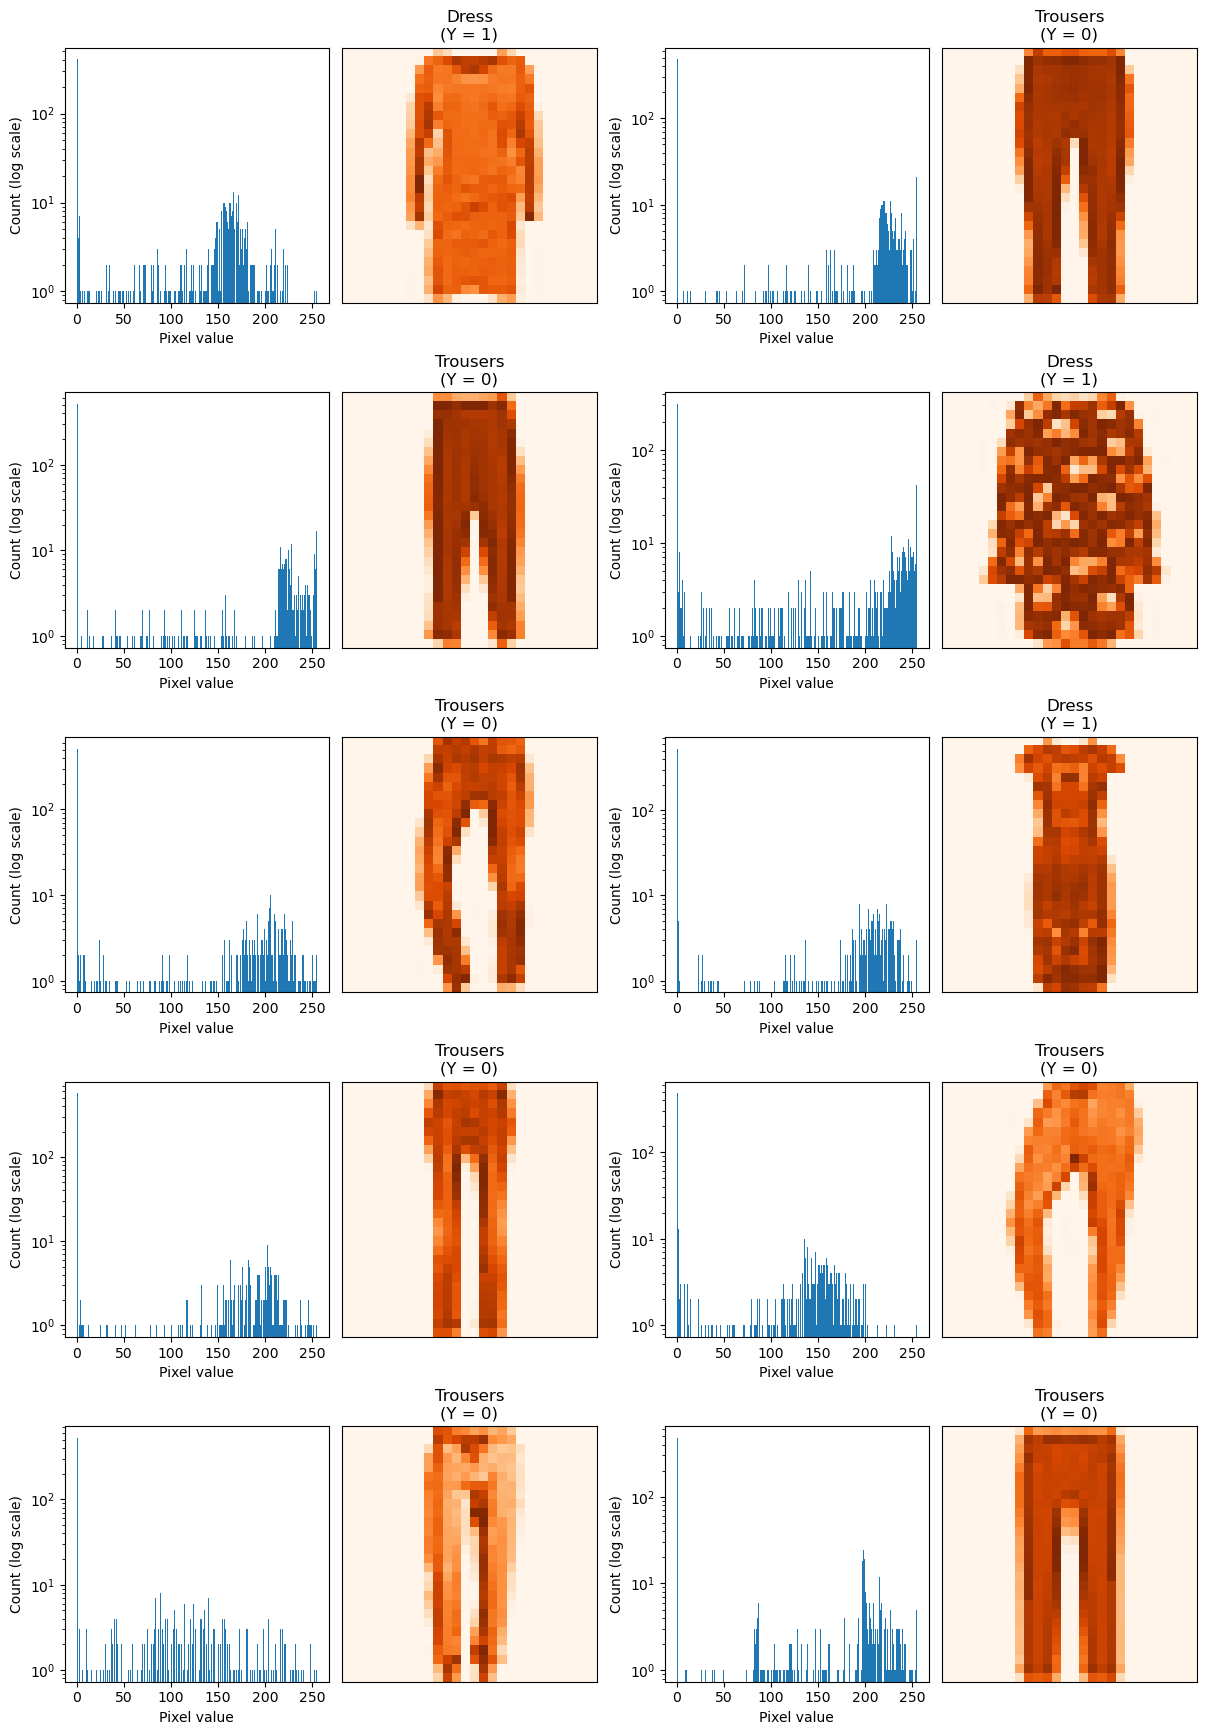

In [22]:
draw_images(images=X_train, y=y_train, scale=3, shape=(5, 2), rd_seed=random_seed)

Also we can look at some specific image for more analysis.

In [28]:
def inspect_image(image, label=None, index=None, suptitle=None):
    if isinstance(image, pd.DataFrame):
        image = pd.Series(image.iloc[0])
    display(image.describe())
    image_arr = image.to_numpy()
    image = image_arr.reshape((28, 28))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4), constrained_layout=True)
    pos = ax1.imshow(image, cmap="Oranges", interpolation="nearest")
    ax1.set_xticks([])
    ax1.set_yticks([])
    if label:
        title = f"{'Trousers' if label == 0 else 'Dress'}"
        if index:
            title += "\n" + f"{index}"
        ax1.set_title(title)
    else:
        ax1.set_title("Image")
    fig.colorbar(mappable=pos)

    ax2.hist(image_arr, bins=256)
    ax2.set_yscale('log')
    ax2.set_title("Image histogram")
    ax2.set_ylabel("Count (log scale)")
    ax2.set_xlabel("Pixel value")

    if suptitle:
        fig.suptitle(suptitle)



Now we will pick random image and look at it:

count    784.000000
mean      68.954082
std       80.621709
min        0.000000
25%        0.000000
50%        0.000000
75%      158.250000
max      255.000000
Name: 1669, dtype: float64

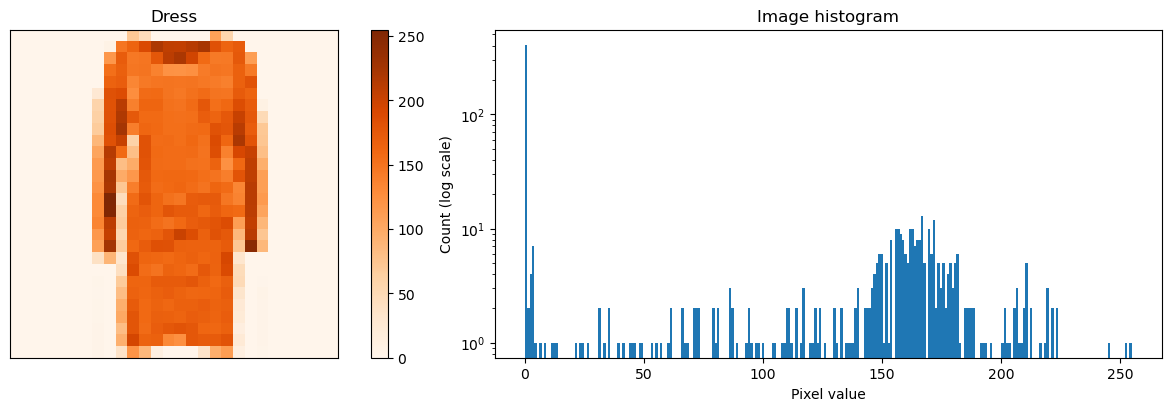

In [29]:
sample_image = X_train.sample(1, random_state=random_seed)
sample_label = y_train[sample_image.index].item()

inspect_image(sample_image, sample_label)

We can see now some more interesting statistics:
- mean pixel value
- min and max pixel value - as expected, it is $0$ and $255$.

In histogram we can see how pixels are distributed. It uses log scale, so the number of pixels with $0$ value is quite high.

For the sake of curiosity, lets inspect mean image across each classe and across both classes.

count    784.000000
mean      61.181063
std       70.673427
min        0.000000
25%        0.652778
50%       18.737847
75%      135.243924
max      187.043056
dtype: float64

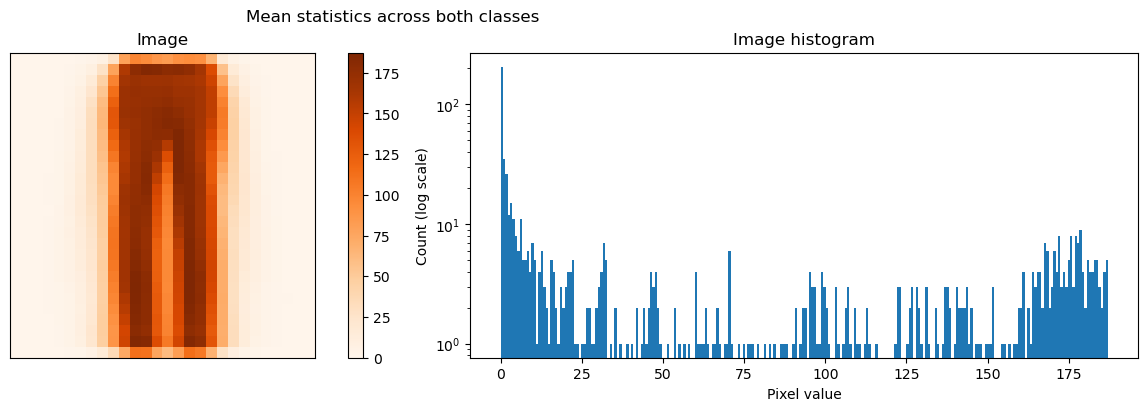

In [31]:
mean_image = pd.Series(X_train.mean(axis=0))
inspect_image(mean_image, suptitle="Mean statistics across both classes")

Mean image across both classes more resembles the Trousers class, than the Dress class. Lets see how both classes rate to each other.

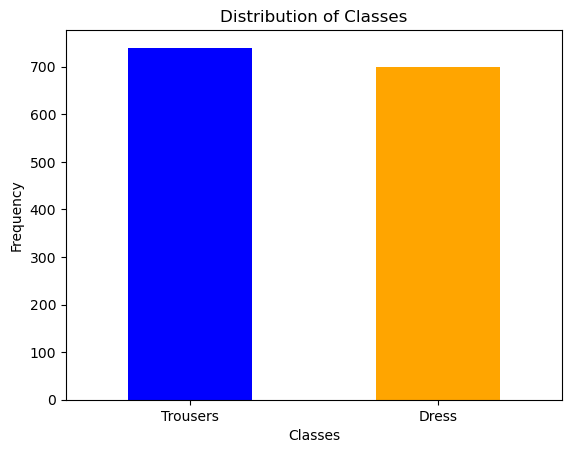

In [12]:
fig, ax = plt.subplots()
class_counts = y_train.value_counts()
g = class_counts.plot(ax=ax, kind='bar', color=['blue', 'orange'])
ax.set_title("Distribution of Classes")
ax.set_xlabel("Classes")
ax.set_ylabel("Frequency")
ax.set_xticks(class_counts.index, labels=['Trousers', 'Dress'], rotation=0)
plt.show()

We see, that Trousers and Dress classes are quite aligned, with little inclination to Trousers.

Now lets see mean image across all Trousers class samples and all Dress class samples:

count    784.000000
mean      56.563679
std       74.190149
min        0.000000
25%        0.620946
50%        6.450000
75%      120.630405
max      207.806757
dtype: float64

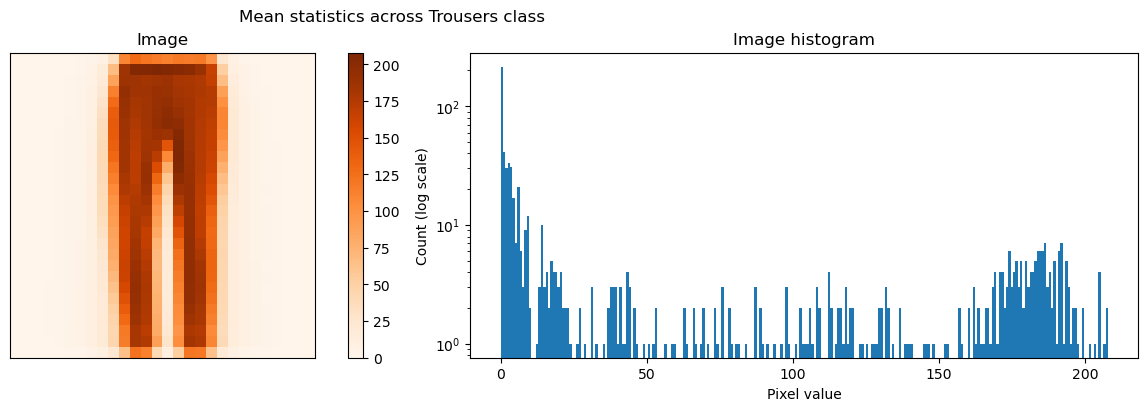

In [13]:
df_trousers = X_train[y_train == 0]
df_trousers_mean = pd.Series(df_trousers.mean(axis=0))
inspect_image(df_trousers_mean, suptitle="Mean statistics across Trousers class")

count    784.000000
mean      66.062298
std       71.472201
min        0.000000
25%        0.598571
50%       29.988571
75%      150.740357
max      189.927143
dtype: float64

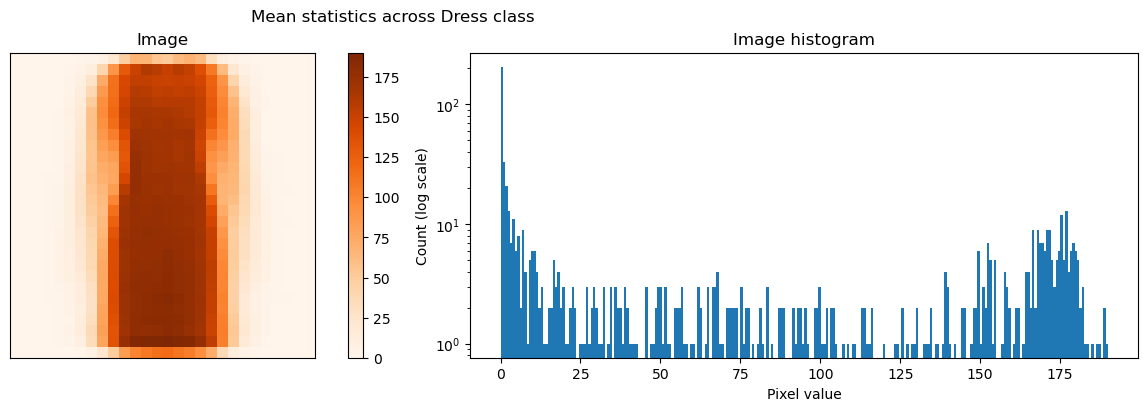

In [32]:
df_dresses = X_train[y_train == 1]
df_dresses_mean = pd.Series(df_dresses.mean(axis=0))
inspect_image(df_dresses_mean, suptitle="Mean statistics across Dress class")

 Notice, that classes can be easily differentiated by pixels positions, while in the same time their histograms look almost identically. This may imply, than in classification position of the vector plays position of the vector plays significant role, while its magnitude does not.

# Classification Without Dimensionality Reduction

Now we will try SVM, NB and LDA models without dimensionality reduction techniques. This will be a good baseline for comparison.

## SVM

First model we will try will be Support Vector Machine. This model is quite effective with highly dimensional data. Even if it is not linearly separable, we have different kernels to overcome this issue. SVM is computationally demanding (especially with RBF kernel), here we have relatively small dataset, so this model should work very good.

Hyperparameters to tune:
- C - regularization hyperparameter of slack variables.
- kernel - which kernel function - linear, polynomial and rbf.
- gamma - used only for polynomial and rbf kernels, as a multiplicative coefficient in kernel functions.
- degree - used only for polynomial kernel to specify degree of the polynomial in kernel function.


Because we will use cross validation and SVM computations may be demanding, we will save results of the training with pickle, so we don't have to run training again (though we can specify to train anew anyway by use_existing parameter).

In [54]:
# global parameters for train function
training_verbosity = 10
cross_validation_folds = 5
n_jobs = 10


def train(X, y, model, param_grid, file_name, use_existing=True):
    if use_existing:
        try:
            with open(file_name, 'rb') as file:
                grid_search = pickle.load(file)
            return grid_search
        except FileNotFoundError:
            print("Could not open file {} (file not found error), proceeding with training.".format(file_name))

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy',
                               cv=cross_validation_folds, n_jobs=n_jobs,
                               verbose=training_verbosity, return_train_score=True)
    grid_search.fit(X=X, y=y)
    with open(file_name, 'wb') as file:
        pickle.dump(grid_search, file=file)

    return grid_search

After each training we will plot accuracy score for training and validation subsets. We will use cross validation, so results will be mean accuracies across all folds. 

In [140]:
def evaluate(grid_search, title):
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)

    mean_train_accuracies = grid_search.cv_results_['mean_train_score']
    mean_val_accuracies = grid_search.cv_results_['mean_test_score']

    fig, ax = plt.subplots(figsize=(20, 7))

    ax.plot(mean_train_accuracies, 'o-', label='train', color='red')
    ax.plot(mean_val_accuracies, 'o-', label='validation', color='navy')
    ax.set_title(title)
    ax.set_xlabel('hyperparameter index')
    ax.set_ylabel('mean accuracy')
    ax.legend(loc="lower right")

In [141]:
C = np.linspace(start=1e-9, stop=1e3, num=100)

param_grid_linear = {
    'kernel': ['linear'],
    'C': C
}

param_grid_poly = {
    'kernel': ['poly'],
    'degree': range(2, 4),
    'gamma': ['scale', 'auto'],
    'C': C
}

param_grid_rbf = {
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto'],
    'C': C
}

param_grid = [param_grid_linear, param_grid_poly, param_grid_rbf]

model = SVC(random_state=random_seed)

#### Original Data

Before trying normalization and standardization, we will try our model on original data without scaling.

In [142]:
grid_search = train(X_cross_val, y_cross_val, model, param_grid=param_grid,
                    file_name=f"train_results/svc/original_rd-{random_seed}.pickle")

Best parameters: {'C': 20.202020203, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation score: 0.98125


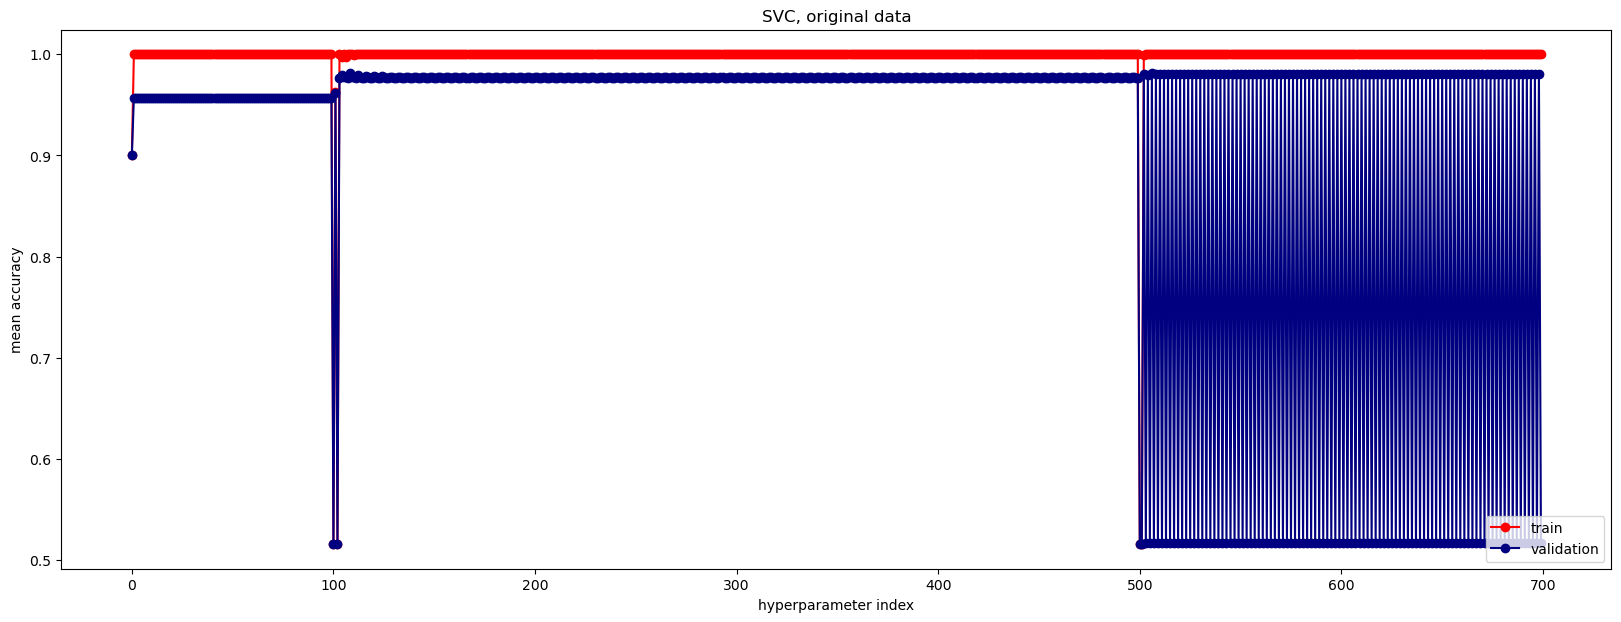

In [143]:
evaluate(grid_search, title="SVC, original data")

On the plot we is possible to distinguish, when the kernel was changed by the sudden drop of accuracy. First the most left part is linear, after that follows polynomial and rbf afterwards.
The best model has cross validation score 0.98125.

#### Normalization

Normalization and standardization can be beneficial, when machine learning model works with distances. But though SVM works with distances under the hood, our data have the same scaling, so it is quite possible we will not have dramatically better results. 

In [57]:
scaler = MinMaxScaler()
X_cross_val_normalized = scaler.fit_transform(X_cross_val)

In [ ]:
grid_search = train(X_cross_val_normalized, y_cross_val, model, param_grid=param_grid,
                    file_name=f"train_results/svc/normalization_rd-{random_seed}.pickle")

Best parameters: {'C': 20.202020203, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation score: 0.9820833333333333


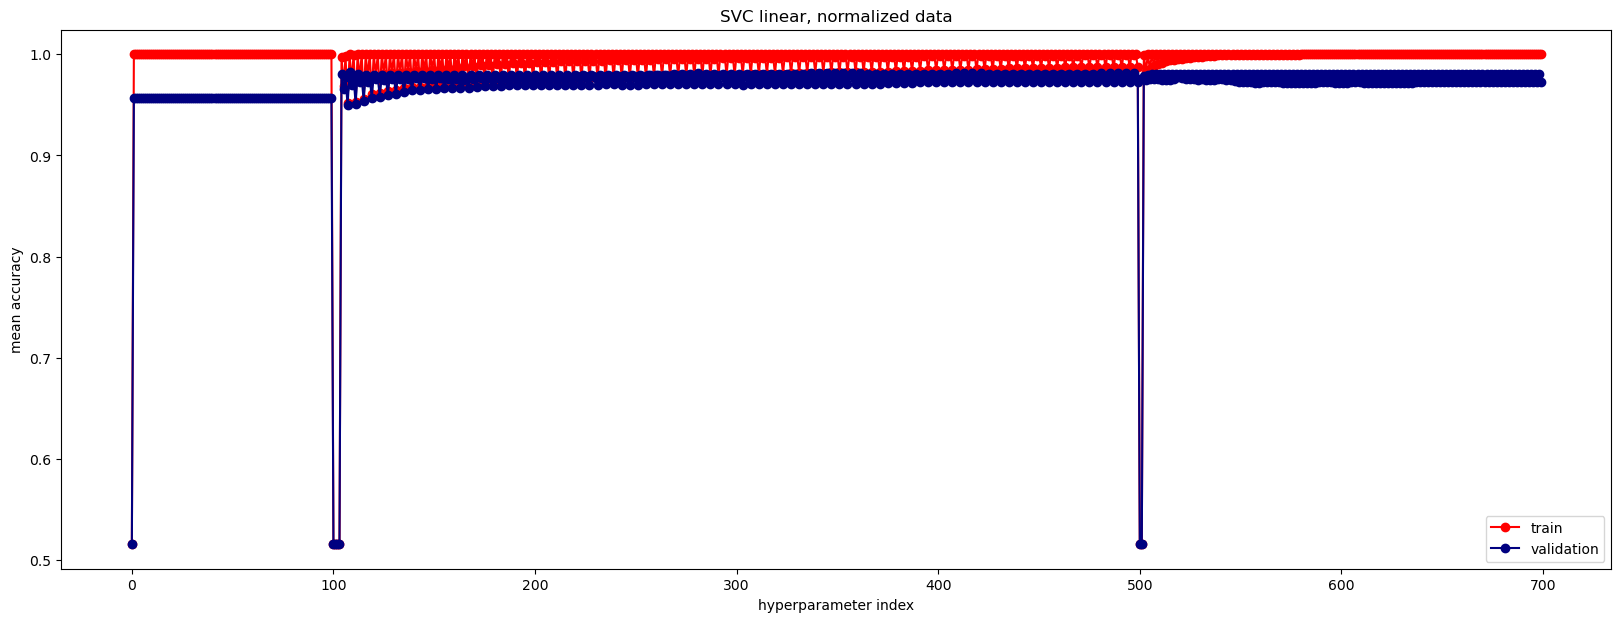

In [71]:
evaluate(grid_search, title="SVC linear, normalized data")

We can see, that best parameters for normalization are same as for original data, but results are slightly (very very slightly) better. Difference is so small, that it may be just difference in computational operations.

In [73]:
scaler = StandardScaler()
X_cross_val_standardized = scaler.fit_transform(X_cross_val)

In [ ]:
grid_search = train(X_cross_val_standardized, y_cross_val, model, param_grid=param_grid,
                    file_name=f"train_results/svc/standardization_rd-{random_seed}.pickle")

Best parameters: {'C': 20.202020203, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation score: 0.9808333333333333


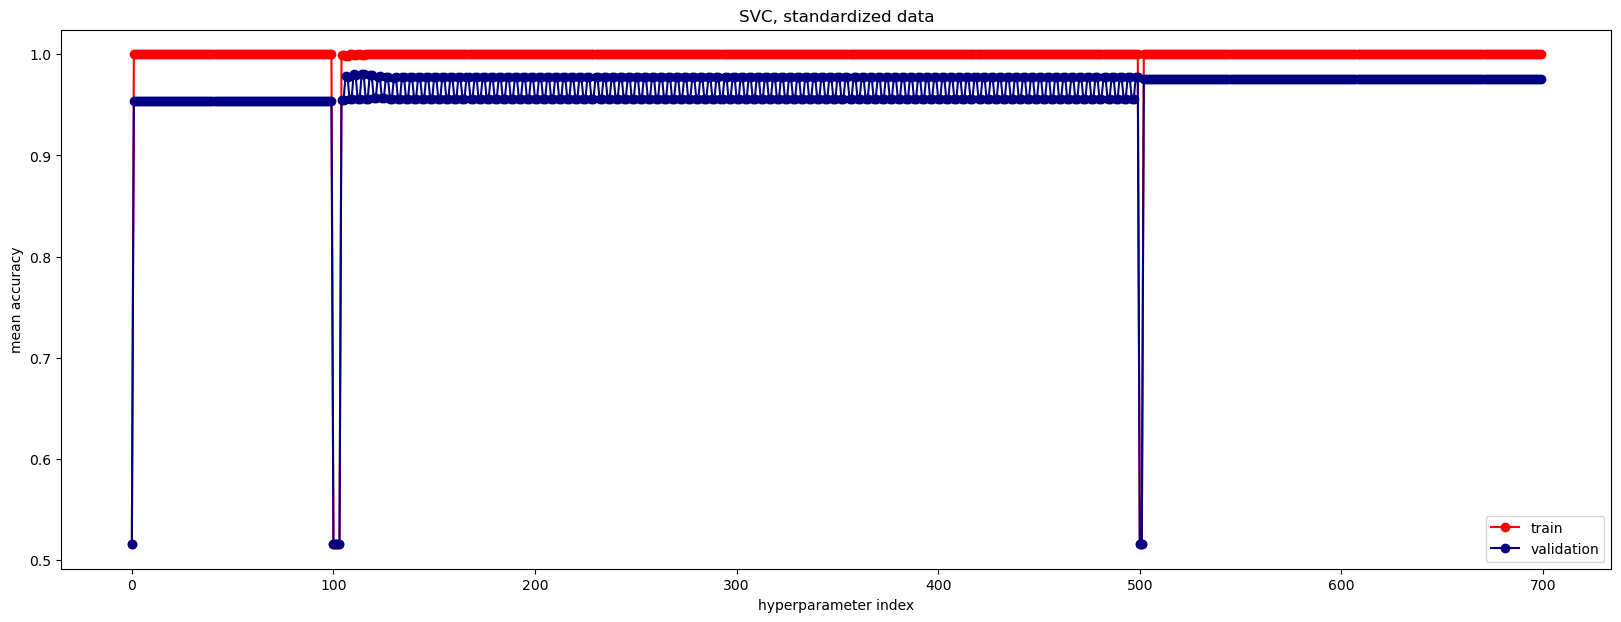

In [75]:
evaluate(grid_search, title="SVC, standardized data")

## Naive Bayes

Naive Bayes model has very important feature - it is very good against the Curse of dimensionality, so it may be quite good for image classification. The drawback of this model is when we have not enough data to cover all outcomes in datapoints distribution, so we will get collapse of prediction to 0. Fortunately, there is *alpha* smoothing parameter which will help use to avoid this issue.

Hyperparameters:
- alpha - in every Naive Bayes model we will have this hyperparameter to finetune
- binarize - this hyperparameter is usable only in Bernoulli Naive Bayes model. It represents value by which binarize feature - for example for binarize=125 all pixels with value more than 125 will be 1, others will be 0. This is important when we will use normalization, because there the binarize parameter will have different range.

Distributions:

We should consider which distribution have our features, so we can train our model with respect to our expert distribution. We will discuss those options:
- Bernoulli - we assume that each feature have some Bernoulli distribution. Looking in our data, we know, that for some features there are only 0 values for all images (corner pixels). But for other parts, we may have more interesting distributions - for example for trousers there is a line of dark pixels between legs, while on dresses there are bright pixels. This insight may be helpful in classification.
- Multinomial - is suitable for classification with discrete features, so this may be useful for our task.
- Categorical - we don't categorical features, so we won't use this distribution.
- Gaussian - this may be helpful, if we have features that have gaussian distribution. We won't use this distribution, because it is highly unlikely that we have features from gaussian distribution. Though more correct approach would be test each feature for normality.

It is worth to notice, that in naive bayes we make an assumption, that features are independent. But we work with some structured image, so it may be correct to expect that some pixels are dependent on others.


In [110]:
param_grid = {'alpha': np.linspace(start=0.1, stop=10, num=10),
              'binarize': np.linspace(start=0, stop=255, num=10)}
model = BernoulliNB()

In [111]:
grid_search = train(X_cross_val, y_cross_val, model, param_grid,
                    file_name=f"train_results/naive_bayes/original_rd-{random_seed}.pickle")

Best parameters: {'alpha': 0.1, 'binarize': 28.333333333333332}
Best cross-validation score: 0.9483333333333333


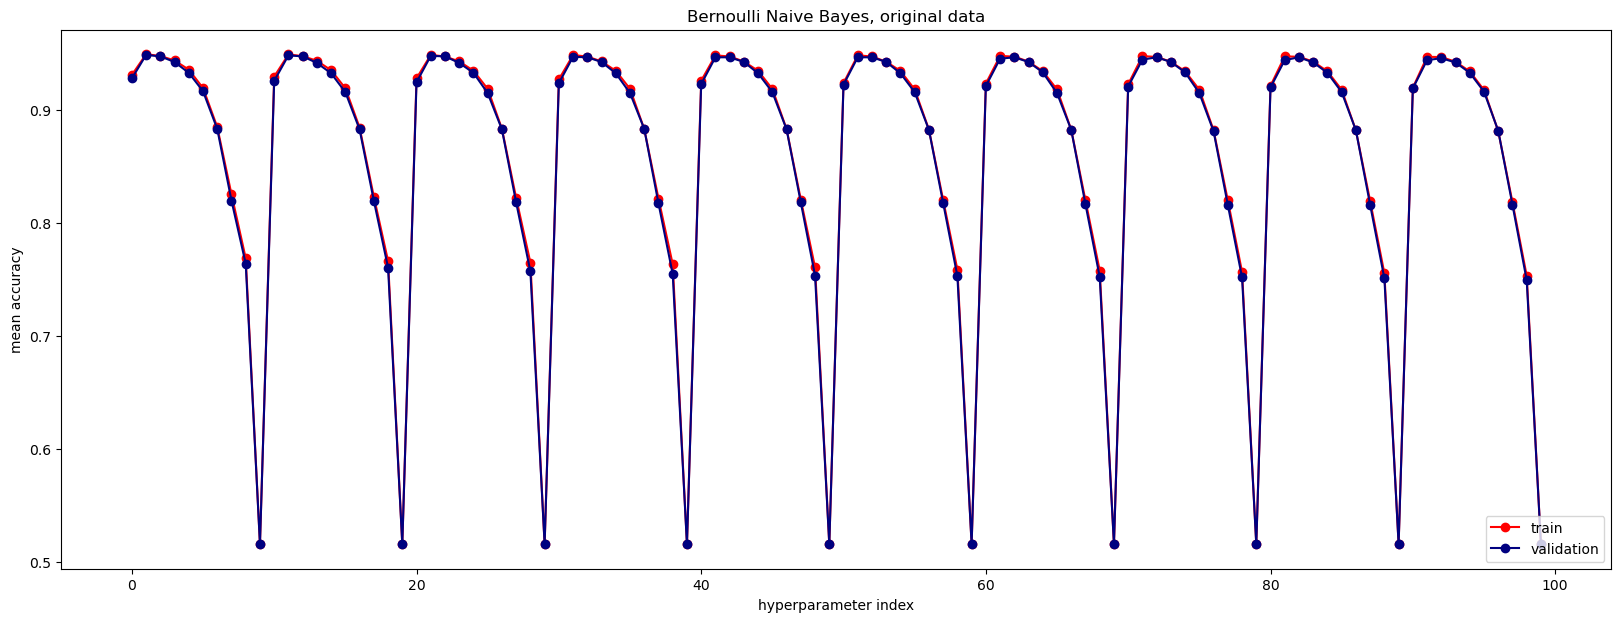

In [112]:
evaluate(grid_search, title="Bernoulli Naive Bayes, original data")

binarize hyperparameter change causes those "hills" shapes, while changes between alpha hyperparameter seem to be be not very influential for our task.

### Normalization

Now lets try normalization. We need also adjust binarize hyperparameter. There should be no difference between normalization and original data, except numerical.

In [ ]:
param_grid = {'alpha': np.linspace(start=0.1, stop=10, num=10),
              'binarize': np.linspace(start=0, stop=1, num=10)}

grid_search = train(X_cross_val_normalized, y_cross_val, model, param_grid,
                    file_name=f"train_results/naive_bayes/normalized_rd-{random_seed}.pickle")

Best parameters: {'alpha': 0.1, 'binarize': 28.333333333333332}
Best cross-validation score: 0.9483333333333333


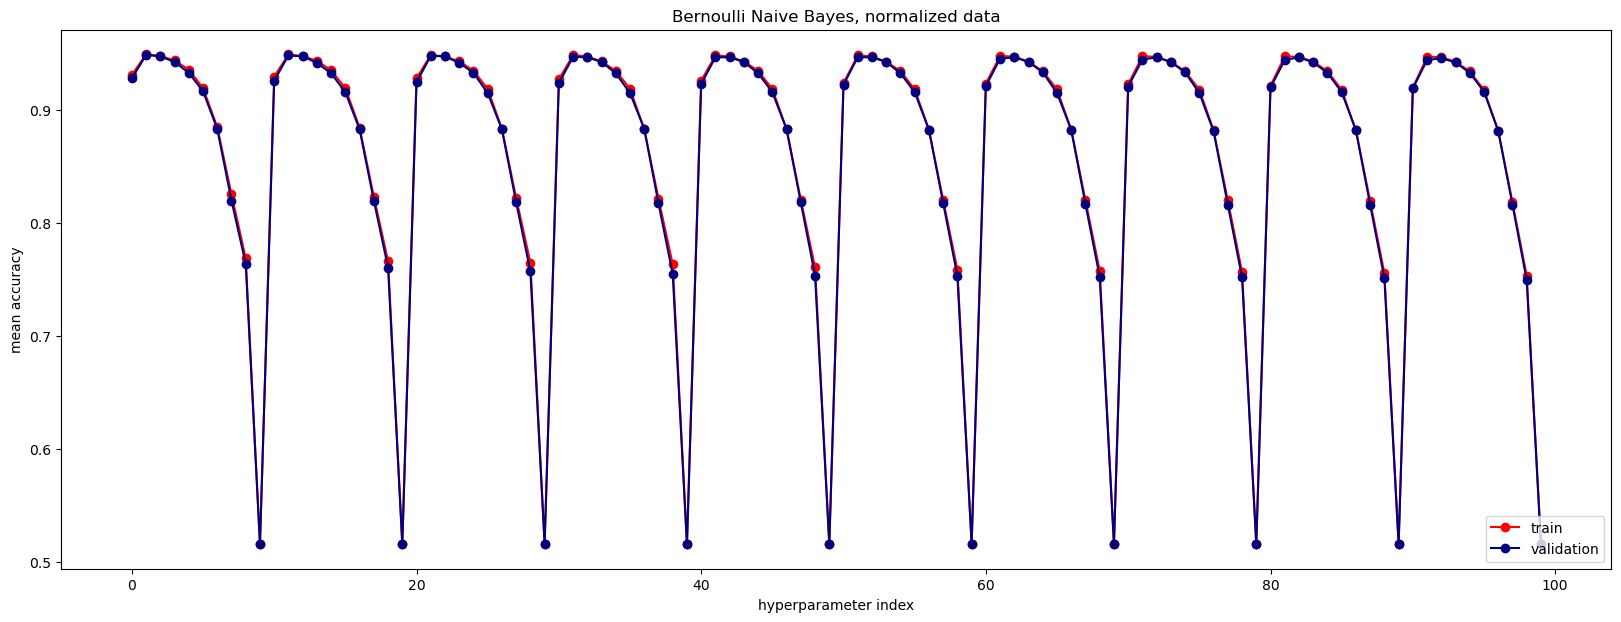

In [113]:
evaluate(grid_search, title="Bernoulli Naive Bayes, normalized data")

### Standardization

We cannot use Standardization with Bernoulli Naive Bayes, because feature values will be distributed from -1 to 1, but binarize hyperparameter can be set only as positive number. Anyway, standardization should have same effect as normalization.

## MultinomialNB

There is only alpha hyperparameter we can tune.

In [115]:
param_grid = {"alpha": np.linspace(start=0.1, stop=10, num=100)}
model = MultinomialNB()
grid_search = train(X_cross_val, y_cross_val, model, param_grid,
                    file_name=f"train_results/naive_bayes/multinomial_original_rd-{random_seed}.pickle")

Best parameters: {'alpha': 0.1}
Best cross-validation score: 0.93625


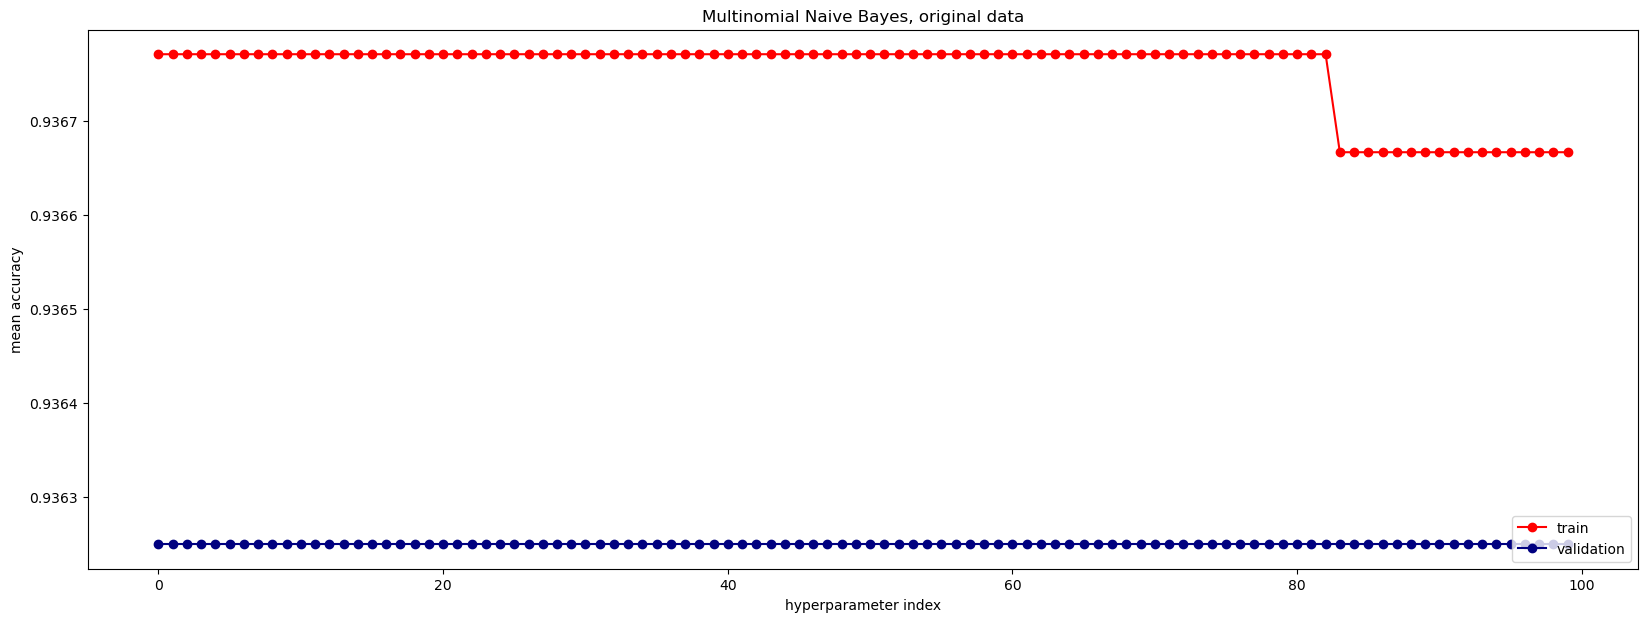

In [116]:
evaluate(grid_search, title="Multinomial Naive Bayes, original data")

## LDA

For LDA we have following hyperparameters:
- solver - using SVD or Least Squares Solution (lsqr). For Eigenvalue Decomposition it cannot solve for our data.

Best parameters: {'solver': 'svd'}
Best cross-validation score: 0.9291666666666666


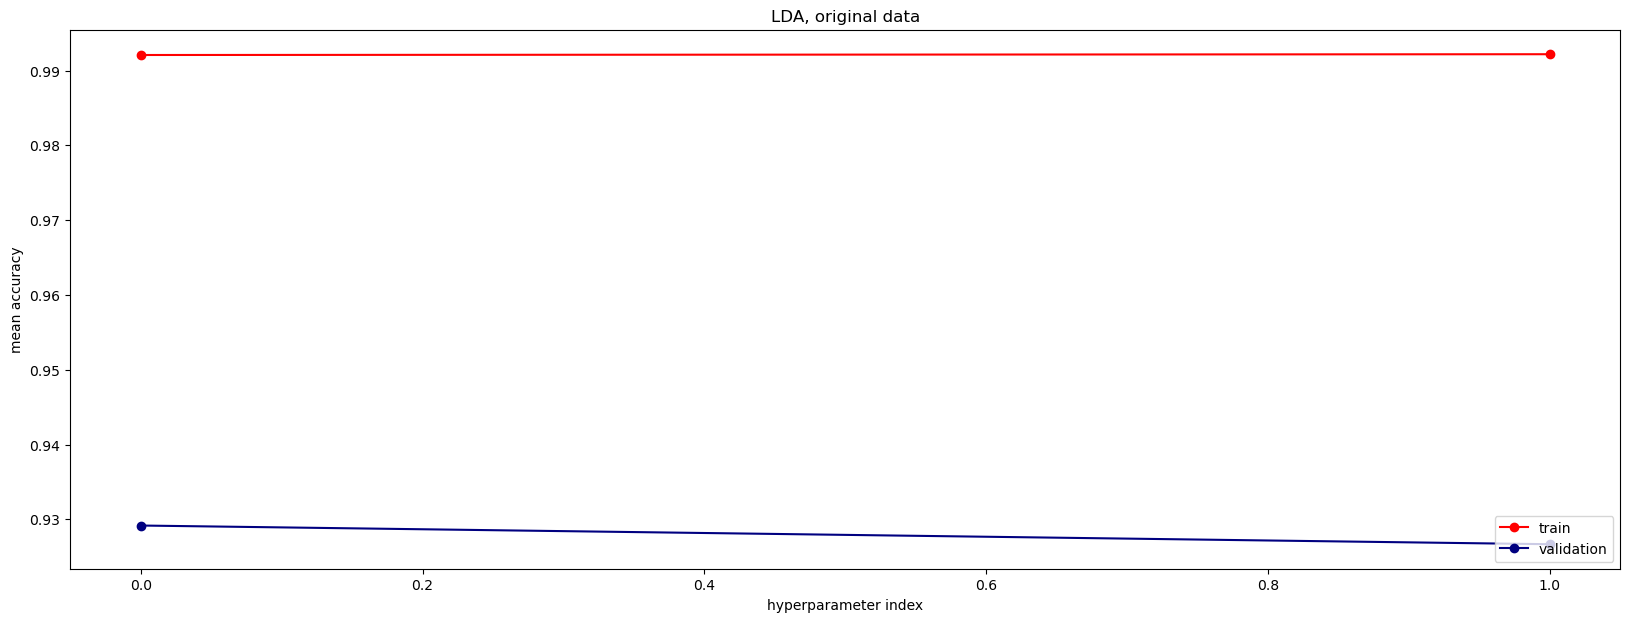

In [119]:
param_grid = {'solver': ['svd', 'lsqr']}
model = LinearDiscriminantAnalysis()
grid_search = train(X_cross_val, y_cross_val, model, param_grid,
                    file_name=f"train_results/lda/original_rd-{random_seed}.pickle")
evaluate(grid_search, "LDA, original data")

### Normalization

Best parameters: {'solver': 'svd'}
Best cross-validation score: 0.9291666666666666


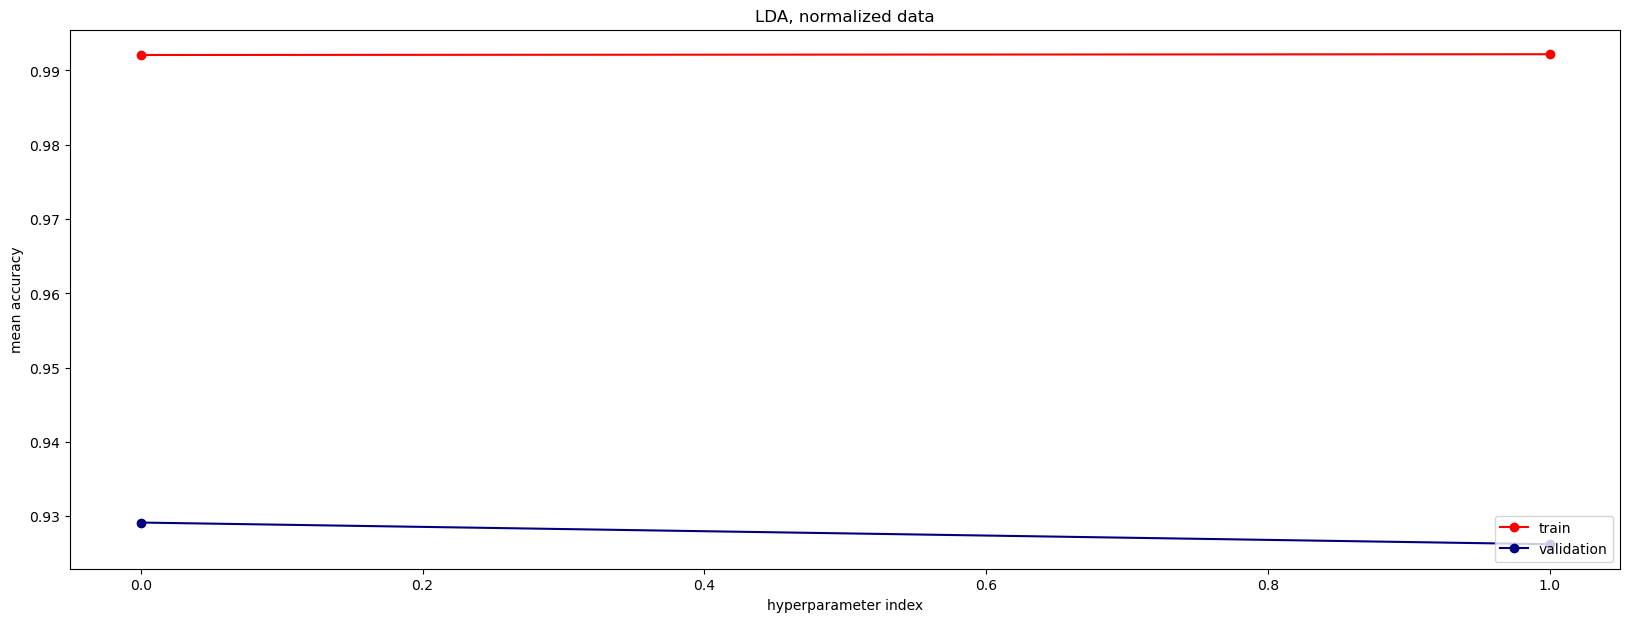

In [121]:
param_grid = {'solver': ['svd', 'lsqr']}
model = LinearDiscriminantAnalysis()
grid_search = train(X_cross_val_normalized, y_cross_val, model, param_grid,
                    file_name=f"train_results/lda/normalized_rd-{random_seed}.pickle")
evaluate(grid_search, "LDA, normalized data")

Best parameters: {'solver': 'lsqr'}
Best cross-validation score: 0.9254166666666667


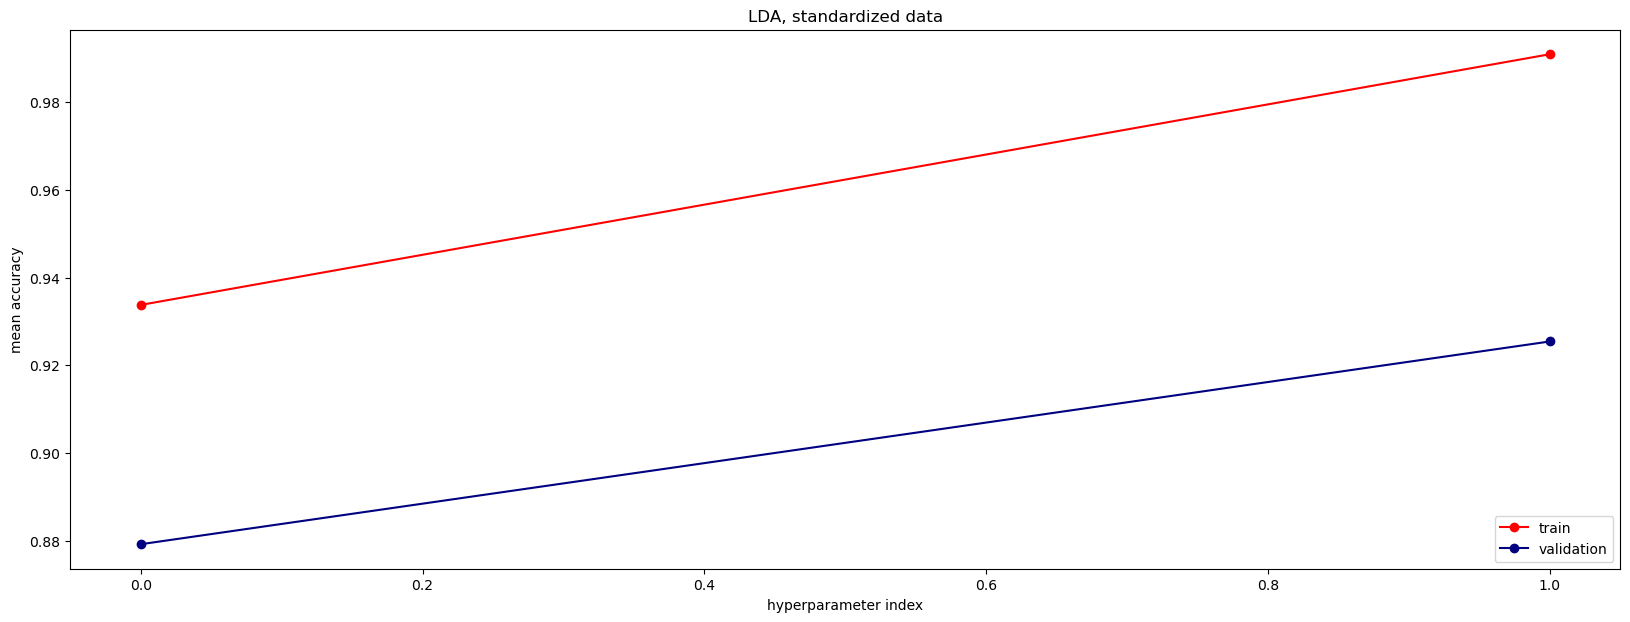

In [122]:
param_grid = {'solver': ['svd', 'lsqr']}
model = LinearDiscriminantAnalysis()
grid_search = train(X_cross_val_standardized, y_cross_val, model, param_grid,
                    file_name=f"train_results/lda/standardized_rd-{random_seed}.pickle")
evaluate(grid_search, "LDA, standardized data")

We can see, that for the LDA, change in scaling makes almost no difference. Though considering that features are scaled identically in original data, rescaling likely won't be very helpful.

# PCA

Nejprve zkusime natrenovat modely na datech bez redukce dimenzionality. Muze nam to dat docela dobrou baselinu pro porovnani kdyz budeme data redukovat. Predem lze rict, ze redukce tady by mela hodne pomoct, protoze nektere dimenze (pixely) jsou nulove napric vsemi obrazky.

# LLE

# Final Model

The best model is SVM without dimensionality reduction, with original data and with best hyperparameters:
- C = 20
- degree = 2
- gamma = scale
- kernel = poly

Cross validation score $\approx$ 0.98 accuracy both with original data and normalization. Because we use cross validation, we can be more confident with our results, so we will expect accuracy at least 95%

In [146]:
best_params = {'C': 20, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
best_model = SVC(**best_params)
best_model.fit(X_cross_val, y_cross_val)

SVC(C=20, degree=2, kernel='poly')

In [208]:
evaluation_df = pd.read_csv("evaluate.csv")

In [209]:
id_df = pd.DataFrame(evaluation_df['ID'])
images_df = evaluation_df.drop('ID', axis=1)

In [210]:
predictions = best_model.predict(images_df)

In [211]:
id_df['label'] = predictions

In [212]:
id_df.head()

,ID,label
0,0,1
1,1,0
2,2,1
3,3,0
4,4,1


In [213]:
id_df.to_csv("results.csv")